<a href="https://colab.research.google.com/github/dlwub/Glucose-Level-Prediction-and-Anomaly-Detection/blob/master/OhioT1DM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


### Import all necessary libraries

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xml.etree.ElementTree as ET
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from keras.models import Model, Sequential
from keras.optimizers import Adam
from keras.layers import Input, LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping

### Step 1. Parse the xml, extract glucose data, and store it in a data frame

In [ ]:
def parse_xml(file_path):
  tree = ET.parse(file_path)
  root = tree.getroot()

  data = []
  for event in root.find("glucose_level").findall("event"):
    time = event.get("ts")
    glucose = event.get("value")

    if time and glucose:
      data.append([time, float(glucose)])

  df = pd.DataFrame(data, columns=["Time", "Glucose"])
  df["Time"] = pd.to_datetime(df["Time"], format="%d-%m-%Y %H:%M:%S")
  return df

data_dir = "/content/gdrive/MyDrive/OhioT1DM/OhioT1DM/OhioT1DM/OhioT1DM"
all_files = [os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith(".xml") ]

df_list = [parse_xml(file) for file in all_files]
df = pd.concat(df_list, ignore_index=True)

df = df.sort_values("Time")
print(df.head())


                     Time  Glucose
17208 2021-08-30 11:53:00    116.0
17209 2021-08-30 11:58:00    117.0
17210 2021-08-30 12:03:00    119.0
17211 2021-08-30 12:08:00    116.0
17212 2021-08-30 12:13:00    111.0


###### Apply scaling

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
df["Glucose Scaled"] = scaler.fit_transform(df[["Glucose"]])
print(df.head())

                     Time  Glucose  Glucose Scaled
17208 2021-08-30 11:53:00    116.0        0.211111
17209 2021-08-30 11:58:00    117.0        0.213889
17210 2021-08-30 12:03:00    119.0        0.219444
17211 2021-08-30 12:08:00    116.0        0.211111
17212 2021-08-30 12:13:00    111.0        0.197222


### Step 2. Data Visualization

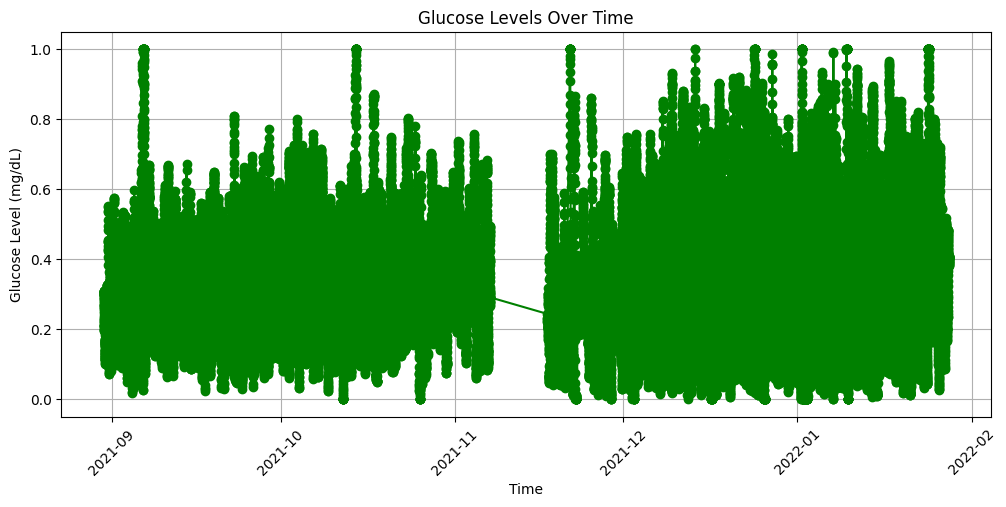

In [ ]:
plt.figure(figsize=(12, 5))
plt.plot(df["Time"], df["Glucose Scaled"], marker="o", linestyle="-", color="green")
plt.xlabel("Time")
plt.ylabel("Glucose Level (mg/dL)")
plt.title("Glucose Levels Over Time")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

### Step 3. Feature Engineering: Check if there are missing values

In [ ]:
print(df.isnull().sum())

Time              0
Glucose           0
Glucose Scaled    0
dtype: int64


###### Extract time-based features

In [ ]:
df["Hour"] = df['Time'].dt.hour
df["DayOfWeek"] = df['Time'].dt.dayofweek
df["Rolling_Mean"] = df["Glucose Scaled"].rolling(window=12).mean() # 1-hour rolling average
df["Rolling_Std"] = df["Glucose Scaled"].rolling(window=12).std()

In [ ]:
print(df.isnull().sum())

Time               0
Glucose            0
Glucose Scaled     0
Hour               0
DayOfWeek          0
Rolling_Mean      11
Rolling_Std       11
dtype: int64


###### Drop missing values

In [ ]:
df.dropna()

,Time,Glucose,Glucose Scaled,Hour,DayOfWeek,Rolling_Mean,Rolling_Std
17219,2021-08-30 12:48:00,126.0,0.238889,12,0,0.210880,0.012837
17220,2021-08-30 12:53:00,131.0,0.252778,12,0,0.214352,0.017641
17221,2021-08-30 12:58:00,136.0,0.266667,12,0,0.218750,0.023214
17222,2021-08-30 13:03:00,141.0,0.280556,13,0,0.223843,0.029289
17223,2021-08-30 13:08:00,145.0,0.291667,13,0,0.230556,0.034816
...,...,...,...,...,...,...,...
17203,2022-01-27 23:18:00,185.0,0.402778,23,3,0.407639,0.002681
17204,2022-01-27 23:23:00,183.0,0.397222,23,3,0.406713,0.004009
17205,2022-01-27 23:28:00,182.0,0.394444,23,3,0.405324,0.005089
17206,2022-01-27 23:33:00,180.0,0.388889,23,3,0.403472,0.006608


### Step 3. Convert Data to Time Series format

In [ ]:
def create_sequences(data, n_steps=12):
  X, y = [], []
  for i in range(len(data) - n_steps):
    X.append(data.iloc[i:i+n_steps].values)
    y.append(data.iloc[i:i+n_steps]["Glucose Scaled"])
  return np.array(X), np.array(y)

features = ["Glucose", "Hour", "DayOfWeek", "Rolling_Mean", "Rolling_Std", "Glucose Scaled"]
X, y = create_sequences(df[features])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
print('Training shape:', X_train.shape)
print("Test shape:", y_train.shape)

Training shape: (68170, 12, 6)
Test shape: (68170, 12)


###### Check if there are still missing values

In [ ]:
print(np.isnan(X_train).sum(), np.isinf(X_train).sum())
print(np.isnan(y_train).sum(), np.isinf(y_train).sum())
print(np.isnan(X_test).sum(), np.isinf(X_test).sum())
print(np.isnan(y_test).sum(), np.isinf(y_test).sum())

132 0
0 0
0 0
0 0


###### Remove rows containing missing values both from X_train and y_train

In [ ]:
nan_mask = np.isnan(X_train).any(axis=(1, 2))
X_train = X_train[~nan_mask]
y_train = y_train[~nan_mask]

print(X_train.shape, y_train.shape)

(68159, 12, 6) (68159, 12)


### Step 4. Train an LSTM model for Glucose prediction

In [ ]:
model = Sequential([
    LSTM(64, activation="relu", return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(32, activation="relu"),
    Dense(1)
])

model.compile(optimizer='adam', loss="mse", metrics=["mae"])
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
2130/2130 ━━━━━━━━━━━━━━━━━━━━ 43s 16ms/step - loss: 76.6245 - mae: 3.3703 - val_loss: 0.0297 - val_mae: 0.1365
Epoch 2/10
2130/2130 ━━━━━━━━━━━━━━━━━━━━ 43s 17ms/step - loss: 0.0214 - mae: 0.1078 - val_loss: 0.0348 - val_mae: 0.1457
Epoch 3/10
2130/2130 ━━━━━━━━━━━━━━━━━━━━ 41s 17ms/step - loss: 0.0179 - mae: 0.1012 - val_loss: 0.0324 - val_mae: 0.1407
Epoch 4/10
2130/2130 ━━━━━━━━━━━━━━━━━━━━ 37s 16ms/step - loss: 0.0169 - mae: 0.0972 - val_loss: 0.0271 - val_mae: 0.1291
Epoch 5/10
2130/2130 ━━━━━━━━━━━━━━━━━━━━ 42s 16ms/step - loss: 0.0162 - mae: 0.0946 - val_loss: 0.0329 - val_mae: 0.1428
Epoch 6/10
2130/2130 ━━━━━━━━━━━━━━━━━━━━ 41s 16ms/step - loss: 0.0159 - mae: 0.0940 - val_loss: 0.0316 - val_mae: 0.1398
Epoch 7/10
2130/2130 ━━━━━━━━━━━━━━━━━━━━ 34s 16ms/step - loss: 0.0160 - mae: 0.0940 - val_loss: 0.0314 - val_mae: 0.1399
Epoch 8/10
2130/2130 ━━━━━━━━━━━━━━━━━━━━ 40s 16ms/step - loss: 0.0159 - mae: 0.0937 - val_loss: 0.0323 - val_mae: 0.1416
Epoch 9/10
2130/2130 ━━

#### Step 5. Evaluate and interpret the model

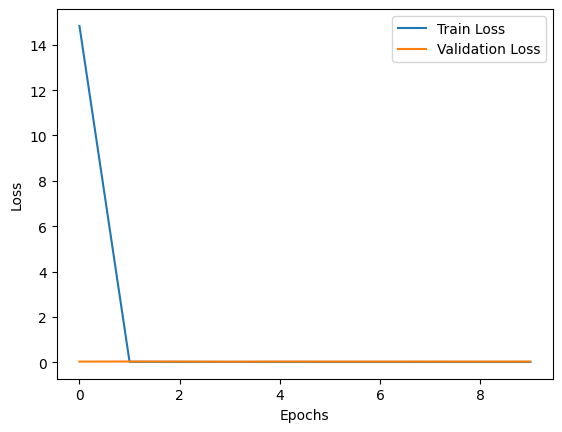

533/533 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step


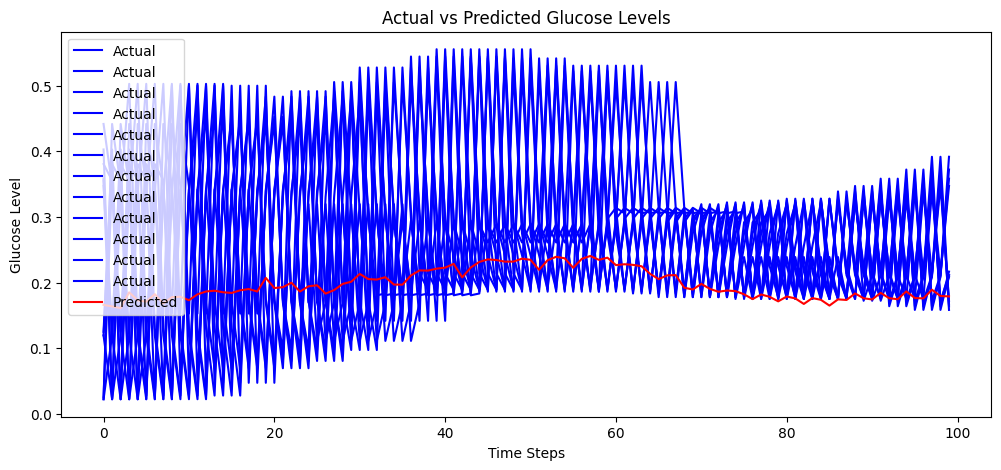

In [ ]:
plt.plot(history.history['loss'], label = 'Train Loss')
plt.plot(history.history['val_loss'], label = 'Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Predict glucose levels

y_pred = model.predict(X_test)

# Plot actual versus predicted glucose levels
plt.figure(figsize=(12, 5))
plt.plot(y_test[:100], label="Actual", color="Blue")
plt.plot(y_pred[:100], label="Predicted", color="Red")
plt.xlabel("Time Steps")
plt.ylabel("Glucose Level")
plt.title("Actual vs Predicted Glucose Levels")
plt.legend()
plt.show()

## Glucose Anomaly Detection
### We use autoencoders to detect anomalies
### Autoencoders are neural networks that map input data to lower dimensional data and then reconstruct it. The reconstruction error will be large for anomalous data points and small for normal data points.

In [ ]:
X = df["Glucose Scaled"].values.reshape(-1, 1)
X_train, X_test = train_test_split(X, test_size=0.2, shuffle=False)
input_dim = X_train.shape[1]
# Input layer
input_layer = Input(shape=(input_dim,))

# Encoder
encoded = Dense(32, activation='relu')(input_layer)
encoded = Dense(16, activation='relu')(encoded)
encoded = Dense(8, activation='relu')(encoded)

# Decoder
decoded = Dense(16, activation='relu')(encoded)
decoded = Dense(32, activation='relu')(decoded)
output_layer = Dense(input_dim, activation='sigmoid')(decoded)

# Autoencoder model
autoencoder = Model(input_layer, output_layer)

autoencoder.compile(optimizer=Adam(), loss='mean_squared_error')
history = autoencoder.fit(X_train, X_train, epochs=50, batch_size=256, validation_data=(X_test, X_test))

X_train_pred = autoencoder.predict(X_train)
X_test_pred = autoencoder.predict(X_test)

train_mse = np.mean(np.square(X_train - X_train_pred), axis = 1)
test_mse = np.mean(np.square(X_test - X_test_pred), axis = 1)

# Anomaly threhold
threshold = np.percentile(train_mse, 95)

# Identify anomalies
anomalies_train = train_mse > threshold
anomalies_test = test_mse > threshold

Epoch 1/50
267/267 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0262 - val_loss: 1.9308e-04
Epoch 2/50
267/267 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.0631e-04 - val_loss: 1.0187e-04
Epoch 3/50
267/267 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 6.3596e-05 - val_loss: 8.7062e-05
Epoch 4/50
267/267 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 5.2511e-05 - val_loss: 7.8595e-05
Epoch 5/50
267/267 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4.1750e-05 - val_loss: 7.3944e-05
Epoch 6/50
267/267 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4.3633e-05 - val_loss: 7.4815e-05
Epoch 7/50
267/267 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4.2258e-05 - val_loss: 7.5729e-05
Epoch 8/50
267/267 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4.2596e-05 - val_loss: 6.9538e-05
Epoch 9/50
267/267 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4.2109e-05 - val_loss: 5.3027e-05
Epoch 10/50
267/267 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 1.9458e-05 - val_loss: 2.0084e-05
Epoch 11/50
267/267 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 1.

### Plots

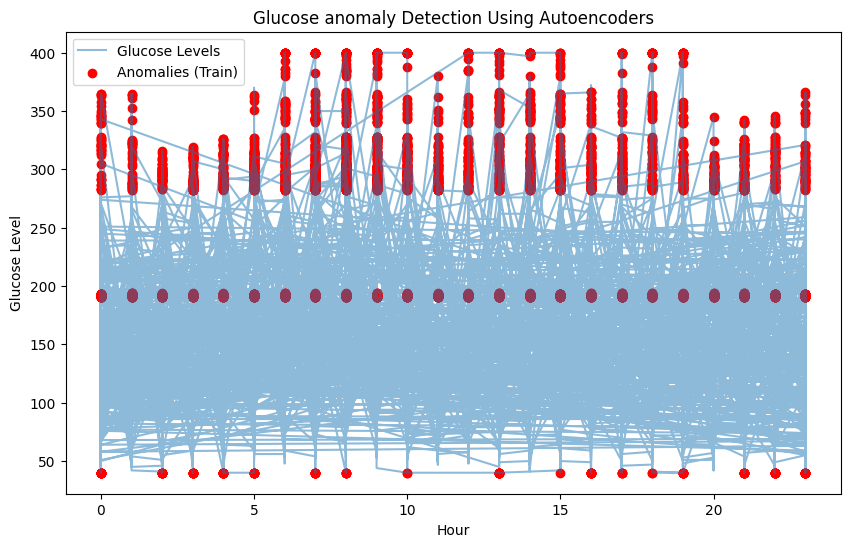

In [ ]:
plt.figure(figsize=(10, 6))
df_copy = df.copy()
df_copy["Anomaly"] = False
train_indices = df_copy.iloc[:len(X_train)].index
test_indices = df_copy.iloc[len(X_train):].index

df_copy.loc[train_indices, "Anomaly"] = train_mse > threshold
df_copy.loc[test_indices, "Anomaly"] = test_mse > threshold
plt.plot(df_copy['Hour'], df_copy['Glucose'], label='Glucose Levels', alpha=0.5)
plt.scatter(df_copy['Hour'][df_copy["Anomaly"]], df['Glucose'][df_copy["Anomaly"]], color='red', label = 'Anomalies (Train)')
plt.xlabel("Hour")
plt.ylabel('Glucose Level')
plt.title('Glucose anomaly Detection Using Autoencoders')
plt.legend()
plt.show()